# Nightvision

Satellite instruments take images across a borad range of wavelengths. Among these, observations in the visible and near-infrared regions of reflected sunlight are vital for measurements of surface and atmospheric properties. However, these observations are only available during the daytime, while observations in the thermal IR wavelengths are available uniformly throughout the day and night. In this challenge, the aim is to take infrared images taken from a satellite at all times of day and night, and predict the visible image corresponding to the IR observations.

---

### Overview

The second generation Meteosat satellites are used to observe the Earth from a geostationary orbit for improving weather forecasts. The SEVIRI instrument makes observations across a range of channels in the visible, near-IR and thermal IR. Visible and near-IR channels can be combined to create a "natural colour" image as shown below. Note that ice clouds appear Cyan due to the use of the 1.6 micron wavelength observations in the place of red light.

<img src=media/seviri_europe_natural_color.png alt="SEVIRI visible (natural colour) image" width=800>

The thermal IR channels can also be combined to create a false colour "cloudtop" composite, like that shown below. Unlike the natural colour composite, this provides imagery during both day and night.

<img src=media/seviri_europe_cloudtop.png alt="SEVIRI IR (cloudtop) image" width=800>

### Objectives

The purpose of this challenge is to develop an algorithm to translate IR images taken at nighttime into visible images seen as if it were daytime. To do this, we will train an ML model to extract the information about visible properties that is hidden in IR channels.

To carry out this image-to-image translation task, we will implement a model using the UNet architecture \[Ronneberger et al., 2015]. UNets are a form of convolutional neural nets that are commonly used for image tranlsation and segmentation tasks. As well as being used on their own, UNet components are also often used in diffusion models and generative adversarial networks.

As part of this computing lab, you will:

  1. Read and visualise RGB composites from visible and infra-red satellite observations
  2. Produce an ML ready dataset of paired satellite images
  3. Develop a simple baseline model and analyse its predictions
  4. Compare different metrics for teesting image to image translation
  5. Train a UNet model to perform image to image translation
  6. Improve this UNet model, by experimenting with different loss functions, layers and improved architectures

---

This challenge is based on the challenge of the same name from the Climate Informatics 2020 hackathon \[Jones and Lguensat, 2021] and the solutions presented in Harder et al. \[2020]

#### References

Harder, P. et al. NightVision: Generating Nighttime Satellite Imagery from Infra-Red Observations. Preprint at https://doi.org/10.48550/arXiv.2011.07017 (2020).

Jones, W. K., Lguensat, R., Charantonis, A. & Watson-Parris, D. The 2020 Climate Informatics Hackathon: Generating Nighttime Satellite Imagery from Infrared Observations. in Proceedings of the 10th International Conference on Climate Informatics 134–138 (Association for Computing Machinery, New York, NY, USA, 2021). doi:10.1145/3429309.3429329.

Ronneberger, O., Fischer, P. & Brox, T. U-Net: Convolutional Networks for Biomedical Image Segmentation. Preprint at https://doi.org/10.48550/arXiv.1505.04597 (2015).

Zhang, Z., Liu, Q. & Wang, Y. Road Extraction by Deep Residual U-Net. Preprint at https://doi.org/10.48550/arXiv.1711.10684 (2017).

Zhou, Z., Siddiquee, M. M. R., Tajbakhsh, N. & Liang, J. UNet++: A Nested U-Net Architecture for Medical Image Segmentation. Preprint at https://doi.org/10.48550/arXiv.1807.10165 (2018).


In [1]:
import pathlib
import tempfile
import urllib
import zipfile

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## 1. Download and read data

The training data for this task consists of paired visible and IR images from SEVIRI. Each image is 128x128 pixels.

First, we need to locate and download the data from the Zenodo repository if it is not already present. This will require 500MB of storage, and takes about a minute

In [2]:
data_path = pathlib.Path("/work/scratch-nopw2/iecdt_ai4eo/data/2-nightvision")
if data_path.exists():
    print("Storing data on JASMIN")
else:
    data_path = pathlib.Path("../../data/2-nightvision")
    print("Storing data locally")
    if not data_path.exists():
        data_path.mkdir()

Storing data locally


In [3]:
cloudtop_path = data_path / "cloudtop_patches"
if not cloudtop_path.exists():
    with tempfile.NamedTemporaryFile() as tmp:
        print("Downloading https://zenodo.org/records/14203536/files/cloudtop_patches.zip")
        urllib.request.urlretrieve(
            "https://zenodo.org/records/14203536/files/cloudtop_patches.zip", tmp.name
        )
        print("Extracting cloudtop_patches.zip")
        with zipfile.ZipFile(tmp, 'r') as zip_ref:
            zip_ref.extractall(data_path)

    assert cloudtop_path.exists(), "Download failed!"

In [4]:
natural_colour_path = data_path / "natural_colour_patches"
if not natural_colour_path.exists():
    with tempfile.NamedTemporaryFile() as tmp:
        print("Downloading https://zenodo.org/records/14203536/files/natural_colour_patches.zip")
        urllib.request.urlretrieve(
            "https://zenodo.org/records/14203536/files/natural_colour_patches.zip", tmp.name
        )
        print("Extracting natural_colour_patches.zip")
        with zipfile.ZipFile(tmp, 'r') as zip_ref:
            zip_ref.extractall(data_path)

    assert natural_colour_path.exists(), "Download failed!"

In [5]:
metadata_file = data_path / "metadata.csv"
if not metadata_file.exists():
    print("Downloading https://zenodo.org/records/14203536/files/metadata.csv")
    urllib.request.urlretrieve(
        "https://zenodo.org/records/14203536/files/metadata.csv", metadata_file
    )
    assert metadata_file.exists(), "Download failed!"

Now we can search for the individual files, there should be 8760 of each:

In [6]:
cloudtop_files = sorted(list(cloudtop_path.glob("cloudtop_*.png")))
natural_colour_files = sorted(list(natural_colour_path.glob("natural_colour_*.png")))

In [7]:
print(f'Cloudtop files: {len(cloudtop_files)}, Natural colour files: {len(natural_colour_files)}')

Cloudtop files: 8760, Natural colour files: 8760


Each file is a png image that we can read using `plt.imread` to produce a RGBA array with values between 0 and 1:

In [8]:
cloudtop_image = plt.imread(cloudtop_files[0])
natural_colour_image = plt.imread(natural_colour_files[0])

In [9]:
print(f'Image shape: {natural_colour_image.shape}, min: {natural_colour_image.min()}, max: {natural_colour_image.max()}')

Image shape: (128, 128, 4), min: 0.0, max: 1.0


Now lets visualise a selection of the images:

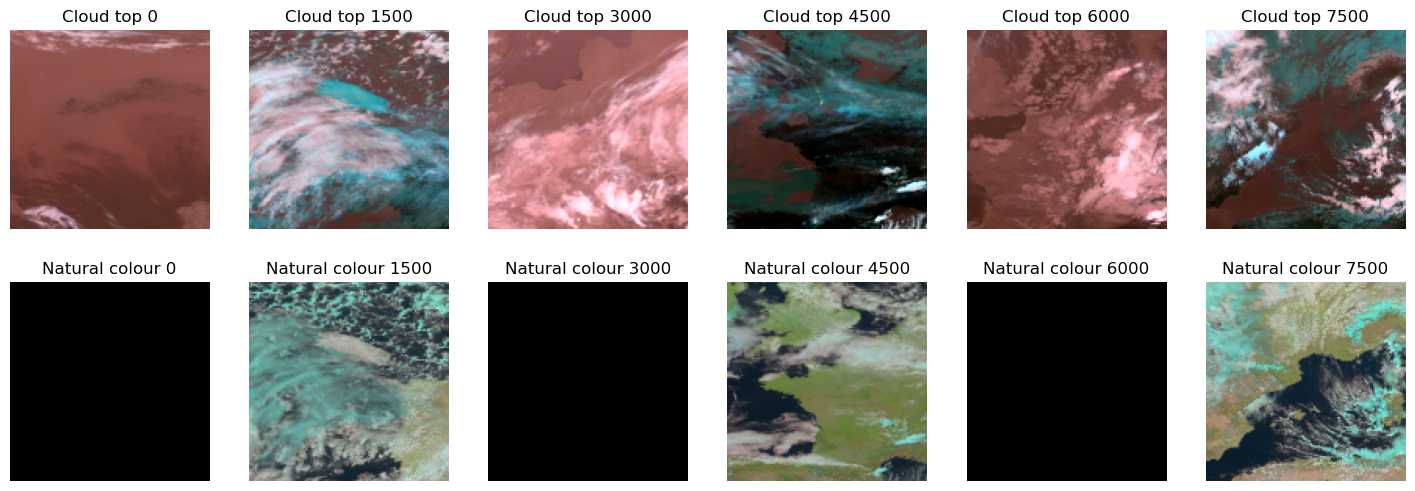

In [10]:
fig, axes = plt.subplots(2, 6, figsize=(18,6))

stride = 1500

for i in range(6):
    cloudtop_image = plt.imread(cloudtop_files[i*stride])
    natural_colour_image = plt.imread(natural_colour_files[i*stride])
    
    axes[0, i].imshow(cloudtop_image)
    axes[0, i].set_axis_off()
    axes[0, i].set_title(f'Cloud top {i*stride}')
    
    axes[1, i].imshow(natural_colour_image)
    axes[1, i].set_axis_off()
    axes[1, i].set_title(f'Natural colour {i*stride}')

As you can see, some of the natural colour images are completely blank. The dataset contains image pairs from all times of day, including at night. To train a model, we need to select only the images where we have a valid target (visible image).

## 2. Data cleaning

The first step in the processing pipeline is to clean the incoming data to ensure we have a good training dataset. A simple approach to removing the nighttime images is to remove image pairs where all of the visible pixels are zero:

In [11]:
# First, load all images into a stack and remove the alpha channel:
natural_colour = np.stack([plt.imread(f)[...,:-1] for f in natural_colour_files])

In [12]:
is_nighttime = np.all(
    natural_colour==0, axis=(1,2,3)
)

print(f'Total nighttime images: {is_nighttime.sum()}')

Total nighttime images: 3467


In [13]:
# Now crop the natural_colour and cloudtop arrays using the nighttime image array:
from itertools import compress

natural_colour_daytime_files = list(compress(natural_colour_files, np.logical_not(is_nighttime)))
cloudtop_daytime_files = list(compress(cloudtop_files, np.logical_not(is_nighttime)))

print(len(natural_colour_daytime_files), len(cloudtop_daytime_files))

5293 5293


Now let's visualise the results:

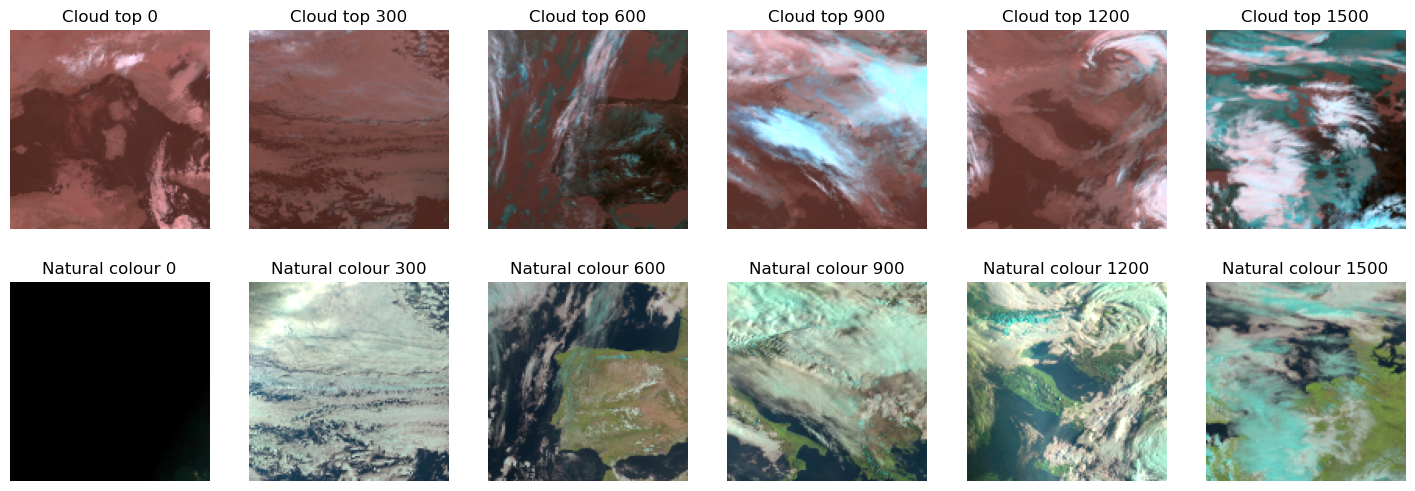

In [14]:
fig, axes = plt.subplots(2, 6, figsize=(18,6))

stride = 300

for i in range(6):
    cloudtop_image = plt.imread(cloudtop_daytime_files[i*stride])
    natural_colour_image = plt.imread(natural_colour_daytime_files[i*stride])
    
    axes[0, i].imshow(cloudtop_image)
    axes[0, i].set_axis_off()
    axes[0, i].set_title(f'Cloud top {i*stride}')
    
    axes[1, i].imshow(natural_colour_image)
    axes[1, i].set_axis_off()
    axes[1, i].set_title(f'Natural colour {i*stride}')

While this has increased the proportion of daytime images, there are still some image pairs where the visible image is mostly darkness, and some where the edge of the image is becoming darker. Now it's your turn to improve the data cleaning to ensure that we have a good quality dataset for model training while maintaining the size of the dataset as much as possible

## Exercises:
1. Plot histograms of the red, green and blue channels for the natural_colour images. What might be a good cutoff values for pixels to be considered in darkness?
2. Rather than requiring all pixels to be in darkness to be considered nighttime, a better threshold might be if more than 50% of pixels are dark. Implement this requirement to create a new nighttime mask.
3. Experiment with different pixel values that are considered dark, and different percentage of the image to be considered dark. How do different choices affect the number of image pairs remaining in the training dataset? What do you think will be the best compromise?
4. Apply your chosen best thresholds to filter the daytime images and plot the results
5. Open the file `metadata.csv` using pandas. Append your nighttime flag as a new column to the dataframe 

Extension questions:

6. What other data cleaning approaches might be useful for removing night time images?
    - The `pysolar` library can be used to calculate the solar zenith angle (the angle in degree of the sun from vertical) using the latitude, longitude and time of day of a place. Use the information in the `metadata.csv` file to calculate the soalr zenith angle of each image pair and use this to filter the nighttime images instead of the pixel values
8. What other data quality issues might be present in earth observation images? How might you address these?

# 3. Splitting train, test and validation data

After data cleaning, an important step is to split the dataset into three separate train, validation and test datasets. A naive approch to this would be to cycle through the image pairs in sets of three, putting one into each of the datasets. However, we need to be wary that these images are also a time series, and that their is covariance between subsequent images and as a result we would be polluting our training dataset with data in the test and validation sets. Instead, let's simply split the dataset into three blocks:

In [21]:
# Open metadata.csv and add the nighttime column if not already done:
patch_metadata = pd.read_csv(data_path/"metadata.csv")
patch_metadata["date"] = pd.to_datetime(patch_metadata.date)
patch_metadata["nighttime"] = is_nighttime

In [22]:
patch_metadata

cloudtop_file      natural_colour_file                date  \
0     cloudtop_0000.png  natural_colour_0000.png 2019-01-01 00:00:00   
1     cloudtop_0001.png  natural_colour_0001.png 2019-01-01 01:00:00   
2     cloudtop_0002.png  natural_colour_0002.png 2019-01-01 02:00:00   
3     cloudtop_0003.png  natural_colour_0003.png 2019-01-01 03:00:00   
4     cloudtop_0004.png  natural_colour_0004.png 2019-01-01 04:00:00   
...                 ...                      ...                 ...   
8755  cloudtop_8755.png  natural_colour_8755.png 2019-12-31 19:00:00   
8756  cloudtop_8756.png  natural_colour_8756.png 2019-12-31 20:00:00   
8757  cloudtop_8757.png  natural_colour_8757.png 2019-12-31 21:00:00   
8758  cloudtop_8758.png  natural_colour_8758.png 2019-12-31 22:00:00   
8759  cloudtop_8759.png  natural_colour_8759.png 2019-12-31 23:00:00   

      longitude  latitude  nighttime  
0         -13.5      48.3       True  
1         -17.5      37.0       True  
2          19.0      46.7       True  
3         -17.3      52.7       True  
4         -20.5      50.4       True  
...         ...       ...        ...  
8755      -16.7      47.1       True  
8756        3.0      46.5       True  
8757      -23.0      52.6       True  
8758       -8.0      41.4       True  
8759       -1.2      43.1       True  

[8760 rows x 6 columns]

In [23]:
patch_metadata["split"] = ""

In [24]:
# Let's naively split the dataset into three
block_size = len(patch_metadata)//3

patch_metadata.loc[:block_size, "split"] = "train"

patch_metadata.loc[block_size:2*block_size, "split"] = "test"

patch_metadata.loc[2*block_size:3*block_size, "split"] = "validate"

# Remove nighttime patches
patch_metadata.loc[patch_metadata.nighttime, "split"] = ""

In [25]:
patch_metadata

cloudtop_file      natural_colour_file                date  \
0     cloudtop_0000.png  natural_colour_0000.png 2019-01-01 00:00:00   
1     cloudtop_0001.png  natural_colour_0001.png 2019-01-01 01:00:00   
2     cloudtop_0002.png  natural_colour_0002.png 2019-01-01 02:00:00   
3     cloudtop_0003.png  natural_colour_0003.png 2019-01-01 03:00:00   
4     cloudtop_0004.png  natural_colour_0004.png 2019-01-01 04:00:00   
...                 ...                      ...                 ...   
8755  cloudtop_8755.png  natural_colour_8755.png 2019-12-31 19:00:00   
8756  cloudtop_8756.png  natural_colour_8756.png 2019-12-31 20:00:00   
8757  cloudtop_8757.png  natural_colour_8757.png 2019-12-31 21:00:00   
8758  cloudtop_8758.png  natural_colour_8758.png 2019-12-31 22:00:00   
8759  cloudtop_8759.png  natural_colour_8759.png 2019-12-31 23:00:00   

      longitude  latitude  nighttime split  
0         -13.5      48.3       True        
1         -17.5      37.0       True        
2          19.0      46.7       True        
3         -17.3      52.7       True        
4         -20.5      50.4       True        
...         ...       ...        ...   ...  
8755      -16.7      47.1       True        
8756        3.0      46.5       True        
8757      -23.0      52.6       True        
8758       -8.0      41.4       True        
8759       -1.2      43.1       True        

[8760 rows x 7 columns]

In [26]:
(patch_metadata.split=="train").sum(), (patch_metadata.split=="test").sum(), (patch_metadata.split=="validate").sum()

(np.int64(1062), np.int64(1287), np.int64(1101))

Now create a new splits file and save to disk:

In [27]:
splits = patch_metadata.loc[patch_metadata.nighttime==False, ["cloudtop_file", "natural_colour_file", "split"]].reset_index(drop=True)

In [28]:
splits

cloudtop_file      natural_colour_file     split
0     cloudtop_0008.png  natural_colour_0008.png     train
1     cloudtop_0009.png  natural_colour_0009.png     train
2     cloudtop_0011.png  natural_colour_0011.png     train
3     cloudtop_0012.png  natural_colour_0012.png     train
4     cloudtop_0013.png  natural_colour_0013.png     train
...                 ...                      ...       ...
3445  cloudtop_8748.png  natural_colour_8748.png  validate
3446  cloudtop_8749.png  natural_colour_8749.png  validate
3447  cloudtop_8750.png  natural_colour_8750.png  validate
3448  cloudtop_8751.png  natural_colour_8751.png  validate
3449  cloudtop_8752.png  natural_colour_8752.png  validate

[3450 rows x 3 columns]

In [29]:
splits.to_csv(data_path/"splits.csv", index=False)

This produces three datasets of nearly equal length. However this is far from the best way to do this

## Exercises:

1. Over what time scales do you think earth observation images have significant covariance with each other? Does this vary with the location or phenomena you are observing?
2. What issues might we face with EO data by splitting our datasets into completely discrete sections for train, test and validate?
3. What is a better choice for the size of each chunk of dataset to ensure good coverage of the full time series without covariance?

Extension questions:

4. Download the file https://zenodo.org/records/4061336/files/Dates_train_CI20.npy which contains an array of dates corresponding the each image. Can you think of a better way to split the dataset using the date information?

# 4. Baseline

First, lets create a simple baseline to compare our models against. This is a naive solution based on analog methods (aka K-NN regression), but used here for regression instead of forecasting. The idea consists in taking for a test sample its nearest neighbor training cloud top image, then using its corresponding true colour image as the prediction.

In [32]:
# Load training data into memory
train_split = splits[splits.split=="train"].reset_index(drop=True)

cloudtop_train = np.stack([
    plt.imread(cloudtop_path/cloudtop_file)[...,:-1] for cloudtop_file in train_split.cloudtop_file
])

natural_colour_train = np.stack([
    plt.imread(natural_colour_path/natural_colour_file)[...,:-1] for natural_colour_file in train_split.natural_colour_file
])

In [33]:
# We can use the BallTree from scikit-learn to find nearest neighbours
from sklearn.neighbors import BallTree

# Now simply add all of our training dataset:
tree = BallTree(
    cloudtop_train.reshape((cloudtop_train.shape[0],-1)), 
    leaf_size=2
)

To use the model, we simply query the balltree object using the test image:

In [34]:
test_split = splits[splits.split=="test"].reset_index(drop=True)

In [35]:
# k sets the number of nearest neighbours to return. Here we set it to 1
test_image = plt.imread(cloudtop_path/test_split.cloudtop_file[0])[...,:-1]

dist, prediction = tree.query(test_image.reshape((1,-1)), k=1) 

# Print the closest (and only) neighbour
print(f'Closest match: image {prediction[0][0]}, distance: {dist[0][0]}')

Closest match: image 1144, distance: 37.959727901744856


Let's plot a few images to see what the predictions actually look like:

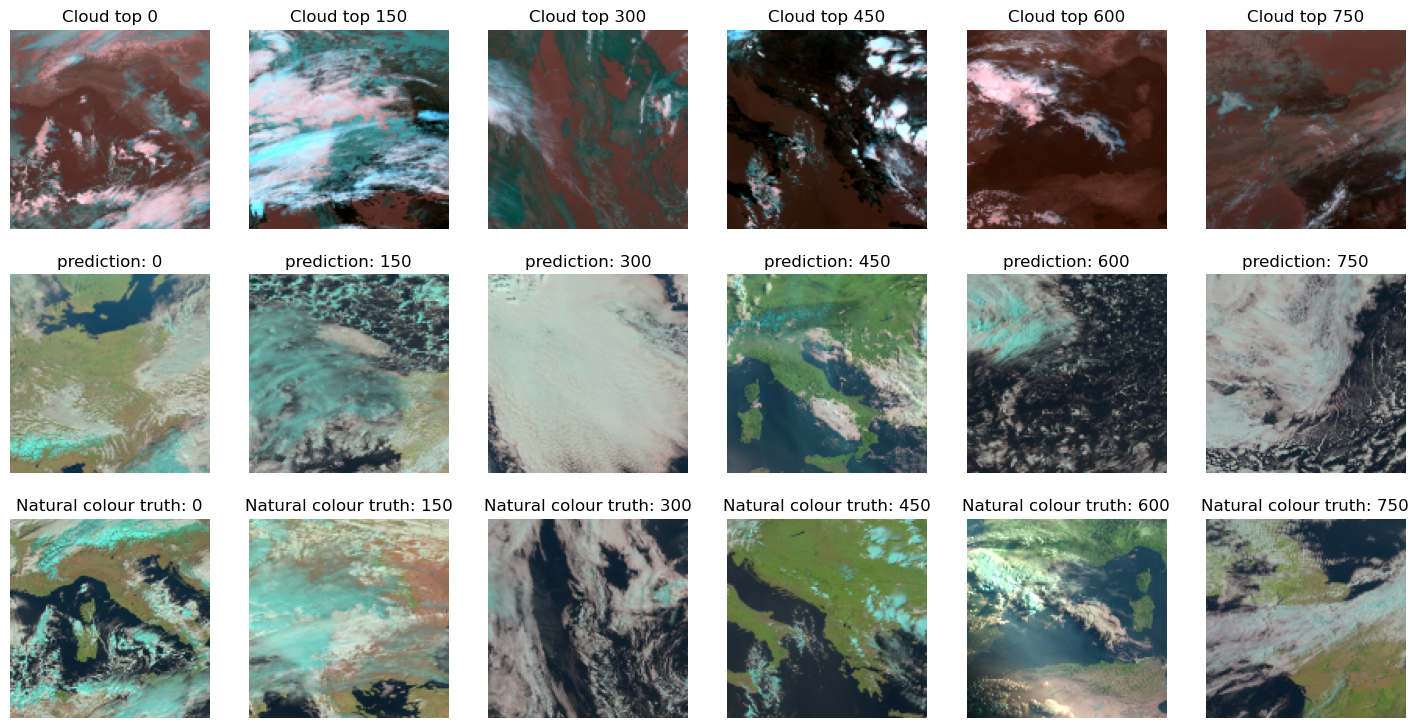

In [36]:
fig, axes = plt.subplots(3, 6, figsize=(18,9))

stride = 150

for i in range(6):
    cloudtop_image = plt.imread(cloudtop_path/test_split.cloudtop_file[i*stride])[...,:-1]
    natural_colour_image = plt.imread(natural_colour_path/test_split.natural_colour_file[i*stride])[...,:-1]
    
    dist, prediction = tree.query(cloudtop_image.reshape((1,-1)), k=1) 

    prediction_image = plt.imread(natural_colour_path/train_split.natural_colour_file[prediction[0][0]])[...,:-1]
    
    axes[0, i].imshow(cloudtop_image)
    axes[0, i].set_axis_off()
    axes[0, i].set_title(f'Cloud top {i*150}')
    
    axes[1, i].imshow(prediction_image)
    axes[1, i].set_axis_off()
    axes[1, i].set_title(f'prediction: {i*150}')

    axes[2, i].imshow(natural_colour_image)
    axes[2, i].set_axis_off()
    axes[2, i].set_title(f'Natural colour truth: {i*150}')


Surprisingly, some of these actually look quite close! However, as these all these predictions are real images, they look "right" to us even if they are not actually correct. How can we provide a more quantitative measure of the difference between the predictions and the true values?

# 5. Metrics

Metrics are important for evaluating any ML task. Here we will implement three different, commonly used metrics to see how they compare:

 - RMSE
 - PSNR
 - SSIM

In [37]:
import skimage.metrics

In [38]:
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
# Define rmse
rmse = lambda img0, img1: mean_squared_error(img0, img1)**0.5
# Define options for ssim
from functools import partial
psnr = partial(peak_signal_noise_ratio, data_range=1)
ssim = partial(structural_similarity, data_range=1, channel_axis=-1)

Now, let's plot the same examples again and see what the scores are:

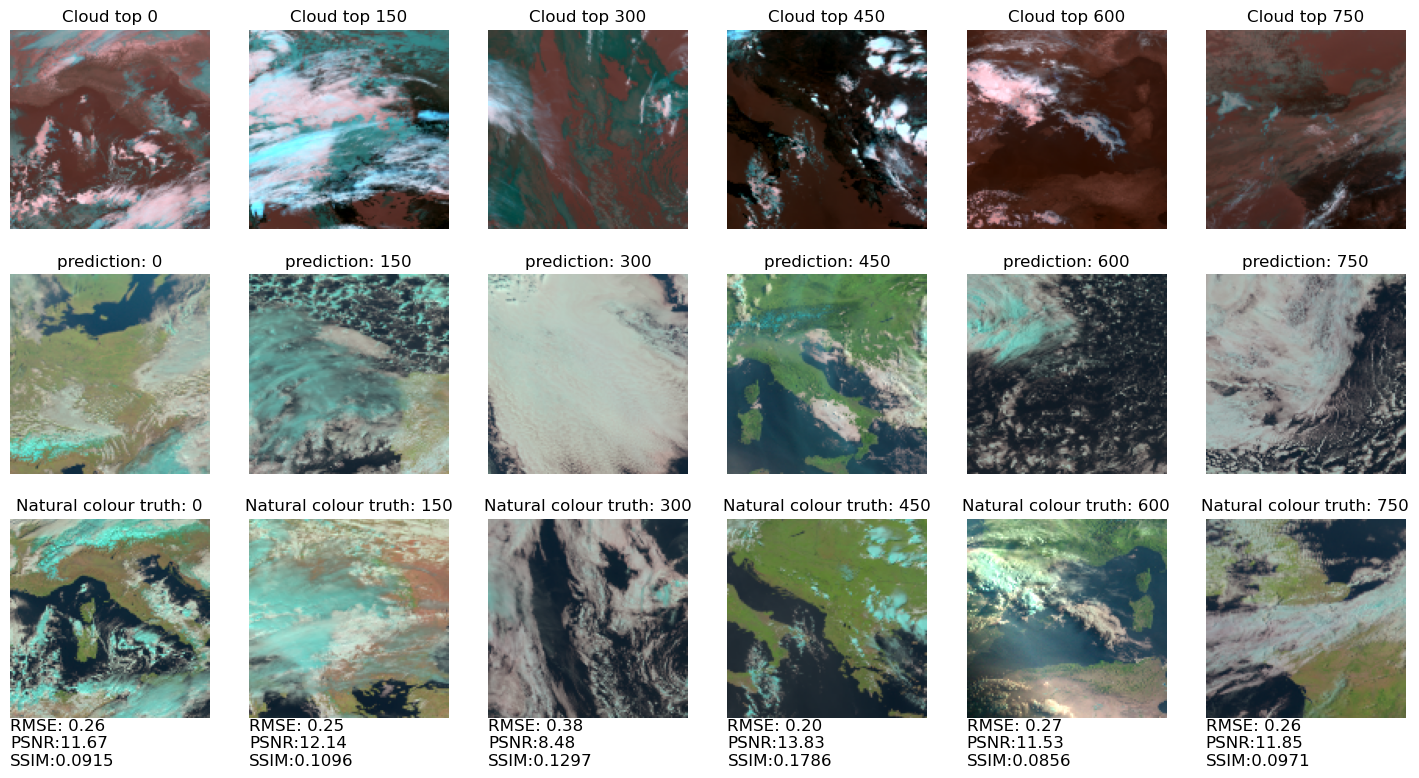

In [39]:
fig, axes = plt.subplots(3, 6, figsize=(18,9))

for i in range(6):
    cloudtop_image = plt.imread(cloudtop_path/test_split.cloudtop_file[i*stride])[...,:-1]
    natural_colour_image = plt.imread(natural_colour_path/test_split.natural_colour_file[i*stride])[...,:-1]
    
    dist, prediction = tree.query(cloudtop_image.reshape((1,-1)), k=1) 

    prediction_image = plt.imread(natural_colour_path/train_split.natural_colour_file[prediction[0][0]])[...,:-1]
    
    axes[0, i].imshow(cloudtop_image)
    axes[0, i].set_axis_off()
    axes[0, i].set_title(f'Cloud top {i*150}')
    
    axes[1, i].imshow(prediction_image)
    axes[1, i].set_axis_off()
    axes[1, i].set_title(f'prediction: {i*150}')

    axes[2, i].imshow(natural_colour_image)
    axes[2, i].set_axis_off()
    axes[2, i].set_title(f'Natural colour truth: {i*150}')

    fig.text(
        *axes[2,i].get_position().bounds[0:2], 
        f'RMSE: {rmse(prediction_image, natural_colour_image):.2f}' \
        f'\nPSNR:{psnr(prediction_image, natural_colour_image):.2f}' \
        f'\nSSIM:{ssim(prediction_image, natural_colour_image):.4f}',
        ha="left", va="top", fontsize=12
    )

For RMSE a low scores is better. For PSNR and SSIM, high scores are better. As we can see, none of the predictions score very well...

We can calculate the metrics over the entire test set (limit to the first 100, for time), to see how well we are performing overall

In [40]:
cloudtop_test = np.stack([
    plt.imread(cloudtop_path/cloudtop_file)[...,:-1] for cloudtop_file in test_split.cloudtop_file
])

natural_colour_test = np.stack([
    plt.imread(natural_colour_path/natural_colour_file)[...,:-1] for natural_colour_file in test_split.natural_colour_file
])

In [41]:
dist, prediction = tree.query(cloudtop_test[:100].reshape((100,-1)), k=1) 

pred_img = natural_colour_train[prediction[:,0]]
true_img = natural_colour_test[:100]

test_rmse = rmse(pred_img, true_img)
test_psnr = psnr(pred_img, true_img)
test_ssim = ssim(pred_img, true_img)
    
print(f'Mean RMSE: {np.mean(test_rmse)}, \nMean PSNR: {np.mean(test_psnr)}, \nMean SSIM: {np.mean(test_ssim)}')

Mean RMSE: 0.23229483206818996, 
Mean PSNR: 12.679209039400693, 
Mean SSIM: 0.13680820167064667


Overall, these poor results match what we saw in the individual images

## Exercises:

1. Compare each of the metrics to your own evaluation of the quality of the predictions. Which of the metrics do you think is the most useful for this task?
2. Instead of making a prediction based on one nearest neighbour, find the three nearest neighbours and average the result. Plot a few examples, and calculate the average RMSE, PSNR and SSIM of the predictions. Do you get better results? Do the predictions look realistic to you? What happens if you keep increasing the number of neighbours?

# 6. UNet pipeline

CNN models are widely used for regression tasks using images. An image-to-image translation model could be constructed by combining two CNNs to encode and then decode an imahge to produce a prediction. However, this doesn't work very well. As the depth of a CNN increases, the model learns larger scale patterns within the image, but also loses fine grained detail. As a result, you end up with a model that can produce a blurry prediction of the whole image with no details (see below):

<img src=media/CNN_image2image_blurry.png alt="Blurry CNN predictions" width=800>

The UNet model \[Ronneberger et al., 2015] uses CNNs as both the encoder and decoder. However, to preserve fine-grained details, "skip connections" are introduced which transfer information between the encoder and decoder at every depth level (see below):

<img src=media/unet.png alt="UNet architecture" width=800>

While the UNet was originally designed for image segmentation, it is also very good at image-to-image translation. 

In [45]:
import torch
from torch import nn
from lightning.pytorch import LightningModule

### 6.1 Convolution block

The basics unit of a UNet is a sequence of two convolutions, with a ReLU activation after each one:

In [46]:
class ConvBlock(LightningModule):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu1  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.relu2  = nn.ReLU()
        self.layer = nn.Sequential(
            self.conv1, self.relu1, self.conv2, self.relu2
        )
    
    def forward(self, x):
        return self.layer(x)

### 6.2 Encoder

The UNet encoder consists of a series of convolution blocks to the required depth, with a 2x2 max pool operation between each to reduce the spatial scale of the data. The forward function returns a list of features produced by the convolution block at each depth

In [47]:
class UNetEncoder(LightningModule):
    def __init__(self, input_channels: int = 3, initial_layer_channels: int = 32, depth: int = 4):
        super().__init__()
        self.channels = [initial_layer_channels*2**i for i in range(depth+1)]
        
        self.input_block = ConvBlock(input_channels, initial_layer_channels)
        
        self.encode_blocks = nn.ModuleList(
            [ConvBlock(self.channels[i], self.channels[i+1]) for i in range(depth)]
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        features = []
        
        x = self.input_block(x)
        features.append(x)
        
        for block in self.encode_blocks:
            x = self.pool(x)
            x = block(x)
            features.append(x)
        return features[::-1]

### 6.3 Decoder

The decoder works similarly to the encoder, but uses `ConvTranspose2d` to upscale the spatial information. At each depth, the resul of the up-convolution is concatenated with the skip connection features from the encoder. Finally, a convolution is used to transform the output data into a 3 channel image, and the output is clipped to valid values between 0 and 1

In [48]:
class UNetDecoder(LightningModule):
    def __init__(self, output_channels=3, initial_layer_channels: int = 32, depth: int = 4):
        super().__init__()
        self.channels = [initial_layer_channels*2**i for i in range(depth+1)][::-1]
        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(self.channels[i], self.channels[i+1], 2, 2) for i in range(len(self.channels)-1)
        ])
        self.decode_blocks = nn.ModuleList(
            [ConvBlock(self.channels[i], self.channels[i+1]) for i in range(len(self.channels)-1)]
        )
        self.head = nn.Conv2d(initial_layer_channels, output_channels, 1)
        
    def forward(self, x, features):
        for upconv, block, feature in zip(self.upconvs, self.decode_blocks, features):
            x = upconv(x)
            x = torch.cat([x, feature], dim=-3)
            x = block(x)
        x = self.head(x)
        return torch.clamp(x, min=0, max=1)


### 6.4 Full UNet model

The UNet model is created by combining the encoder and decoder:

In [49]:
class Image2Image_UNet(LightningModule):
    def __init__(
        self, 
        input_channels: int = 3, 
        output_channels: int = 3, 
        initial_layer_channels: int = 32, 
        depth: int = 4, 
        learning_rate: float = 1.5e-4,
        loss_function = nn.MSELoss()
    ):
        super().__init__()
        
        # Define encoder and decoder
        self.encoder = UNetEncoder(
            input_channels=input_channels, initial_layer_channels=initial_layer_channels, depth=depth
        )
        self.decoder = UNetDecoder(
            initial_layer_channels=initial_layer_channels, depth=depth
        )
        
        # define & log hyperparameters
        self.learning_rate = learning_rate
        self.save_hyperparameters(ignore=['loss_function'])

        # loss function
        self.loss = loss_function

    def forward(self, x):
        features = self.encoder(x)
        x = self.decoder(features[0], features[1:])
        return x

    def compute_loss(self, batch):
        image, target = batch
        # forward pass
        predictions = self(image).squeeze()
        # calculate loss
        loss = self.loss(predictions, target)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss = self.compute_loss(batch)
        # log training loss
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True
        )
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.compute_loss(batch)
        # log validation loss
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True
        )
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.compute_loss(batch)
        # log test loss
        self.log(
            "test_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True
        )
        return loss

### 6.5 Dataloader

Now we need to create a dataloader that can take our splits file we created earlier and return train, validate and test datasets:

In [50]:
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch import LightningDataModule

class NightvisionDataset(Dataset):
    def __init__(self, cloudtop_files, natural_colour_files):

        super().__init__()
        
        self.cloudtop_files = cloudtop_files
        self.natural_colour_files = natural_colour_files

    def __len__(self):
        return len(self.cloudtop_files)
    
    def __getitem__(self, idx):
        return (
            plt.imread(self.cloudtop_files[idx])[...,:-1].transpose([2,0,1]).astype(np.float32), 
            plt.imread(self.natural_colour_files[idx])[...,:-1].transpose([2,0,1]).astype(np.float32), 
        )

class NightvisionDataloader(LightningDataModule):
    def __init__(
        self, 
        batch_size, 
        splits_file, 
        cloudtop_path, 
        natural_colour_path,
        num_workers=10, 
    ):
        super().__init__()
        self.batch_size = batch_size

        splits_df = pd.read_csv(splits_file)

        train_split = splits_df[splits_df.split=="train"]
        test_split = splits_df[splits_df.split=="test"]
        val_split = splits_df[splits_df.split=="validate"]

        # Get list of files for each split
        self.train_dataset = NightvisionDataset(
            [cloudtop_path/f for f in train_split.cloudtop_file], 
            [natural_colour_path/f for f in train_split.natural_colour_file], 
        )
        self.val_dataset = NightvisionDataset(
            [cloudtop_path/f for f in val_split.cloudtop_file], 
            [natural_colour_path/f for f in val_split.natural_colour_file], 
        )
        self.test_dataset = NightvisionDataset(
            [cloudtop_path/f for f in test_split.cloudtop_file], 
            [natural_colour_path/f for f in test_split.natural_colour_file], 
        )
        
        self.num_workers = num_workers

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True,
            pin_memory=True, 
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            pin_memory=True, 
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            pin_memory=True, 
        )

In [51]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger
from tqdm import tqdm

class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(            
            disable=True,            
        )
        return bar

# Add a logger for metrics and checkpoints
csv_logger = CSVLogger(
    save_dir='',
    name='logs'
)


In [52]:
dl = NightvisionDataloader(
    24, data_path/"splits.csv", data_path/"cloudtop_patches", data_path/"natural_colour_patches", 
)

In [53]:
unet = Image2Image_UNet()

In [58]:
# Initialize the trainer
trainer = Trainer(
    max_epochs=10,
    callbacks=[LitProgressBar()],
    logger=csv_logger,
    log_every_n_steps=10, 
    accelerator="auto", 
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [59]:
trainer.fit(unet, dl)

/Users/jonesw/miniforge3/envs/iecdt-earth-obs/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/version_36/checkpoints exists and is not empty.

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | UNetEncoder | 4.7 M  | train
1 | decoder | UNetDecoder | 3.0 M  | train
2 | loss    | MSELoss     | 0      | train
------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.041    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|█| 48/48 [00:21<00:00,  2.22it/s, v_num=36, train_loss_step=0.014, val_loss_step=0.00904, val_loss_epoch=0.0138, train_loss_epoch=0.0142

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 48/48 [00:21<00:00,  2.21it/s, v_num=36, train_loss_step=0.014, val_loss_step=0.00904, val_loss_epoch=0.0138, train_loss_epoch=0.0142


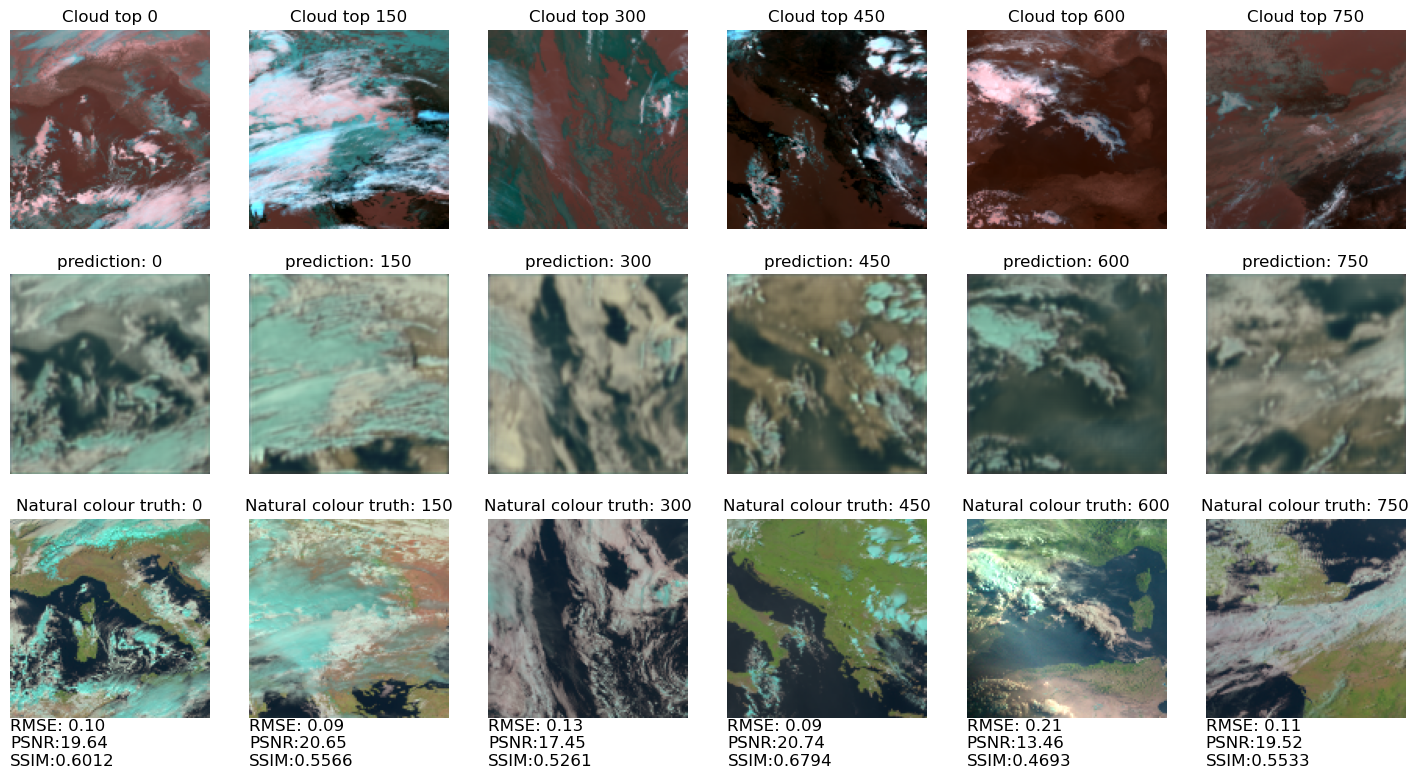

In [60]:
def unet_prediction(image):
    in_img = torch.from_numpy(
        (image.transpose(2,0,1)).astype(np.float32)
    )
    out_img = unet.forward(in_img)
    out_img = out_img.detach().numpy().transpose(1,2,0)
    out_img = np.clip(out_img, 0, 1)
    return out_img

fig, axes = plt.subplots(3, 6, figsize=(18,9))

stride = 150

for i in range(6):
    cloudtop_image = plt.imread(cloudtop_path/test_split.cloudtop_file[i*stride])[...,:-1]
    natural_colour_image = plt.imread(natural_colour_path/test_split.natural_colour_file[i*stride])[...,:-1]
    
    prediction_image = unet_prediction(cloudtop_image)
    
    axes[0, i].imshow(cloudtop_image)
    axes[0, i].set_axis_off()
    axes[0, i].set_title(f'Cloud top {i*150}')
    
    axes[1, i].imshow(prediction_image)
    axes[1, i].set_axis_off()
    axes[1, i].set_title(f'prediction: {i*150}')

    axes[2, i].imshow(natural_colour_image)
    axes[2, i].set_axis_off()
    axes[2, i].set_title(f'Natural colour truth: {i*150}')

    fig.text(
        *axes[2,i].get_position().bounds[0:2], 
        f'RMSE: {rmse(prediction_image, natural_colour_image):.2f}' \
        f'\nPSNR:{psnr(prediction_image, natural_colour_image):.2f}' \
        f'\nSSIM:{ssim(prediction_image, natural_colour_image):.4f}',
        ha="left", va="top", fontsize=12
    )

In [61]:
def unet_multi_prediction(image):
    in_img = torch.from_numpy(
        (image.transpose(0,3,1,2)).astype(np.float32)
    )
    out_img = unet.forward(in_img)
    out_img = out_img.detach().numpy().transpose(0,2,3,1)
    out_img = np.clip(out_img, 0, 1)
    return out_img

pred_img = unet_multi_prediction(cloudtop_test[::10])
true_img = natural_colour_test[::10]

test_rmse = rmse(pred_img, true_img)
test_psnr = psnr(pred_img, true_img)
test_ssim = ssim(pred_img, true_img)
    
print(f'Mean RMSE: {np.mean(test_rmse)}, \nMean PSNR: {np.mean(test_psnr)}, \nMean SSIM: {np.mean(test_ssim)}')

Mean RMSE: 0.11417550380244966, 
Mean PSNR: 18.848541267615445, 
Mean SSIM: 0.74226975440979


### Exercises:
  
  1. Plot some predictions for actual night time images. How good do they look?

  2. Implement SSIM as a loss function and run the model using it instead of MSE. Does it improve the predictions?
  <details>
    <summary>Hints:</summary>
      - For SSIM, higher is better, so to minimise the loss you will have to return 1 - SSIM
      - SSIM only works on one channel. To calculate the SSIM over a multi channel image, calculate the SSIM for each channel separately then average them
      - Remember to set data range to 1!
  </details>

  3. Batch normalisation and dropout layers can help generalise UNet models. Implement these into the convolution block and test the results. What is a good choice for the dropout rate?

  4. Run your best model for more epochs. What is the best score you can achieve? Does the model overfit?

Extension exercises:

  5. Deep residual UNets \[Zhang et al., 2017] use residual units to improve predictions. Write a residual block module and use it in place of the convolution block to train a model.

  6. An issue with the UNet arhcitecure is that higher depths pass through fewer training layers. The UNet++ model \[Zhou et al. 2018] addresses this using nested skip connections. Implement a UNet++ model and compare the results

  7. Generative models are also widely used for image to image translation. Which models would be suitable for this task. If you have time, implement one!